In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torchvision.ops
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [4]:
raw_image_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100"
label_image_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100"
train_dir=raw_image_dir

In [5]:
train_fns = os.listdir(raw_image_dir)
val_fns = os.listdir("C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/val_10")
print(len(train_fns), len(val_fns))

8000 234


In [6]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

transform = T.Resize(size = (512,512))


C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100\00000_FV.png


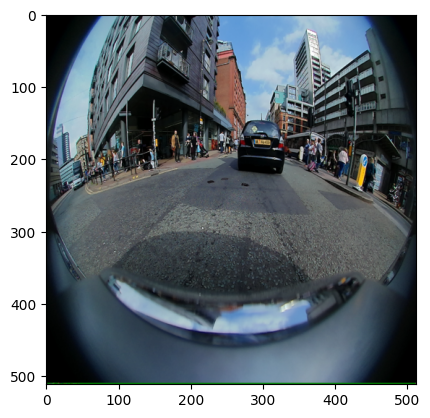

In [7]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = transform(Image.open(sample_image_fp)).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [8]:
train_label_fns = os.listdir(label_image_dir)
val_label_fns = os.listdir("C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/val_10")
print(len(train_label_fns), len(val_label_fns))

8000 234


C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100\00002_FV.png


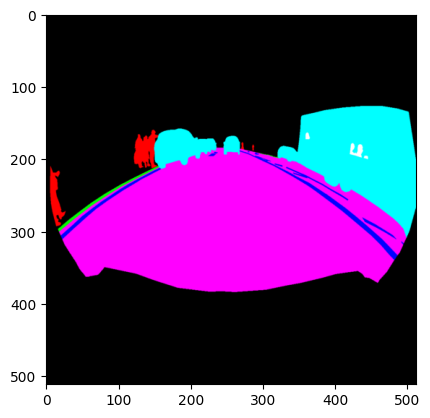

In [9]:
sample_label_fp = os.path.join(label_image_dir, train_label_fns[2])
sample_label = transform(Image.open(sample_label_fp)).convert("RGB")
plt.imshow(sample_label)
print(sample_label_fp)

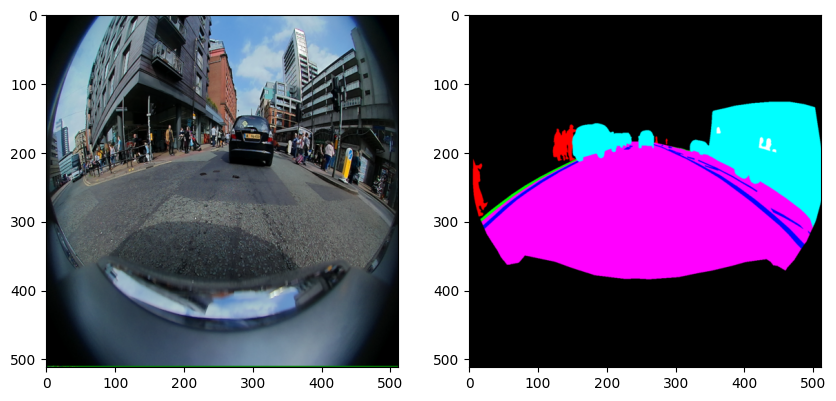

In [10]:

woodscape, label = Image.fromarray(np.array(sample_image)), Image.fromarray(np.array(sample_label))
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(woodscape)
axes[1].imshow(label)

In [11]:
num_items = 1000
color_array = np.random.choice(range(512), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [12]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

C:\Users\yashs\Woodscape\woodscape_cuda_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [13]:
sample_label = label.convert("RGB")

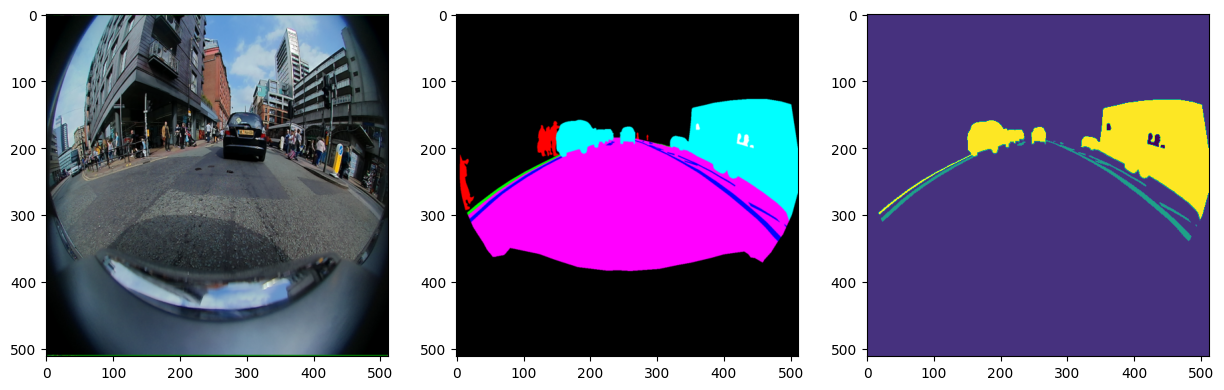

In [14]:
woodscape, label = np.array(sample_image),np.array(sample_label)
label_class = label_model.predict(label.reshape(-1,3)).reshape(512,512)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(woodscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [15]:
label_class

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [16]:
class WoodscapeDataset(Dataset):

  def __init__(self, image_dir, label_dir, label_model):
    self.image_dir = image_dir
    self.label_dir = label_dir
    self.image_fns = os.listdir(image_dir)
    self.label_fns = os.listdir(label_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    label_fn = self.label_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    label_fp = os.path.join(self.label_dir, label_fn)
    image = transform(Image.open(image_fp)).convert("RGB")
    label = transform(Image.open(label_fp)).convert("RGB")
    image = np.array(image)
    woodscape = np.array(image)
    label = np.array(label)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(512,512)
    label_class = torch.Tensor(label_class).long()
    woodscape = self.transform(woodscape)
    return woodscape, label_class
  
  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [17]:
train_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/train_100"
label_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/train_100"
dataset = WoodscapeDataset(train_dir,label_dir, label_model)
print(len(dataset))

8000


In [18]:
woodscape, label_class = dataset[0]
print(woodscape.shape, label_class.shape)

torch.Size([3, 512, 512]) torch.Size([512, 512])


In [19]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 dilation=1,
                 bias=False):
        super(DeformableConv2d, self).__init__()

        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        self.dilation = dilation

        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     dilation=self.dilation,
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(in_channels,
                                        1 * kernel_size[0] * kernel_size[1],
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=self.padding,
                                        dilation=self.dilation,
                                        bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      dilation=self.dilation,
                                      bias=bias)

    def forward(self, x):
        # h, w = x.shape[2:]
        # max_offset = max(h, w)/4.

        offset = self.offset_conv(x)  # .clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        # op = (n - (k * d - 1) + 2p / s)
        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          dilation=self.dilation)
        return x

In [20]:
class DUNet(nn.Module):
    
    def __init__(self, num_classes):
        super(DUNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle=self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, 
                                               kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = DeformableConv2d(in_channels=1024, out_channels=512, 
                                             kernel_size=3, stride=1, padding=1)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, 
                                               kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = DeformableConv2d(in_channels=512, out_channels=256, 
                                             kernel_size=3, stride=1, padding=1)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, 
                                               kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                                               kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [21]:
model = DUNet(num_classes=num_classes)

In [22]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).__next__()
print(X.shape, Y.shape)

8000 2000
torch.Size([4, 3, 512, 512]) torch.Size([4, 512, 512])


In [23]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 512, 512])


In [24]:
batch_size = 1
epochs = 20
lr = 0.00001
weight_decay=0.001

In [25]:
dataset = WoodscapeDataset(train_dir,label_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [26]:
model = DUNet(num_classes = num_classes).to(device)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr,weight_decay=weight_decay)

In [28]:
import time
step_losses = []
epoch_losses = []

total_start = time.time()
for epoch in tqdm(range(epochs)):
    epoch_start = time.time()
    print("--------------------- Epoch number: "+str(epoch)+" ---------------------------------")
    epoch_loss = 0
    counter = 0
    for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
        counter=counter+1
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        if counter%500==0:
            print("step number",counter)
            print("epoch_loss : ",epoch_loss)
            print("step_losses : ",loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))
    epoch_end = time.time()
    print("Epoch Time Taken",epoch_end - epoch_start)
total_end = time.time()
print("Total Time Taken",total_end - total_start)

  0%|          | 0/20 [00:00<?, ?it/s]

--------------------- Epoch number: 0 ---------------------------------


  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  1123.427191734314
step_losses :  2.092106342315674
step number 1000
epoch_loss :  2127.880254983902
step_losses :  2.226461410522461
step number 1500
epoch_loss :  2977.360944867134
step_losses :  2.0073413848876953
step number 2000
epoch_loss :  3763.128675341606
step_losses :  1.0135819911956787
step number 2500
epoch_loss :  4377.090053856373
step_losses :  1.3472867012023926
step number 3000
epoch_loss :  4938.879126489162
step_losses :  0.7746329307556152
step number 3500
epoch_loss :  5372.845848709345
step_losses :  1.0037217140197754
step number 4000
epoch_loss :  5778.948826044798
step_losses :  0.46619486808776855
step number 4500
epoch_loss :  6158.4670286774635
step_losses :  0.43483656644821167
step number 5000
epoch_loss :  6450.56427885592
step_losses :  0.320293128490448
step number 5500
epoch_loss :  6780.390969321132
step_losses :  0.8524512052536011
step number 6000
epoch_loss :  7044.056789115071
step_losses :  0.47407132387161255
step 

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  169.5582927837968
step_losses :  0.7956486940383911
step number 1000
epoch_loss :  299.7243845015764
step_losses :  0.35972732305526733
step number 1500
epoch_loss :  402.15181693434715
step_losses :  0.16066929697990417
step number 2000
epoch_loss :  509.6741099655628
step_losses :  0.28599774837493896
step number 2500
epoch_loss :  606.8749489188194
step_losses :  0.16083890199661255
step number 3000
epoch_loss :  695.8370544835925
step_losses :  0.14852145314216614
step number 3500
epoch_loss :  774.600174203515
step_losses :  0.5519828796386719
step number 4000
epoch_loss :  858.060487985611
step_losses :  0.16472455859184265
step number 4500
epoch_loss :  936.9493453875184
step_losses :  0.10808548331260681
step number 5000
epoch_loss :  1021.2622671835124
step_losses :  0.12718719244003296
step number 5500
epoch_loss :  1101.7284365035594
step_losses :  0.2565780282020569
step number 6000
epoch_loss :  1172.616499260068
step_losses :  0.0899482220411

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  64.37037432566285
step_losses :  0.5773041844367981
step number 1000
epoch_loss :  120.15765680372715
step_losses :  0.11198245733976364
step number 1500
epoch_loss :  167.83027670532465
step_losses :  0.08304944634437561
step number 2000
epoch_loss :  219.45760134235024
step_losses :  0.16152140498161316
step number 2500
epoch_loss :  275.094999615103
step_losses :  0.07771486043930054
step number 3000
epoch_loss :  327.692082952708
step_losses :  0.11279506236314774
step number 3500
epoch_loss :  378.79108001850545
step_losses :  0.278531014919281
step number 4000
epoch_loss :  431.5074777100235
step_losses :  0.11972509324550629
step number 4500
epoch_loss :  483.154349302873
step_losses :  0.07065003365278244
step number 5000
epoch_loss :  541.9090257864445
step_losses :  0.08727571368217468
step number 5500
epoch_loss :  598.381469650194
step_losses :  0.1727128028869629
step number 6000
epoch_loss :  648.1409085597843
step_losses :  0.068094760179519

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  53.53054229915142
step_losses :  0.30822619795799255
step number 1000
epoch_loss :  101.13145026005805
step_losses :  0.09124436974525452
step number 1500
epoch_loss :  139.52723577432334
step_losses :  0.06493265926837921
step number 2000
epoch_loss :  181.35993188805878
step_losses :  0.09691798686981201
step number 2500
epoch_loss :  226.214795621112
step_losses :  0.05881069600582123
step number 3000
epoch_loss :  270.5572570990771
step_losses :  0.09955263882875443
step number 3500
epoch_loss :  316.15951779298484
step_losses :  0.23473814129829407
step number 4000
epoch_loss :  359.679243972525
step_losses :  0.08569235354661942
step number 4500
epoch_loss :  404.7756572458893
step_losses :  0.06139593571424484
step number 5000
epoch_loss :  454.1030495110899
step_losses :  0.08280861377716064
step number 5500
epoch_loss :  503.00848771445453
step_losses :  0.13724201917648315
step number 6000
epoch_loss :  546.3764922525734
step_losses :  0.05458527

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  47.86657284386456
step_losses :  0.16361744701862335
step number 1000
epoch_loss :  89.36170469596982
step_losses :  0.07862859964370728
step number 1500
epoch_loss :  123.8678712695837
step_losses :  0.05832776427268982
step number 2000
epoch_loss :  160.46101420931518
step_losses :  0.0728142186999321
step number 2500
epoch_loss :  200.3734908681363
step_losses :  0.05240114778280258
step number 3000
epoch_loss :  239.992844350636
step_losses :  0.09535843133926392
step number 3500
epoch_loss :  282.74797350913286
step_losses :  0.34018611907958984
step number 4000
epoch_loss :  322.48225730471313
step_losses :  0.07918838411569595
step number 4500
epoch_loss :  363.1677004471421
step_losses :  0.05938401818275452
step number 5000
epoch_loss :  406.85831904783845
step_losses :  0.0820440798997879
step number 5500
epoch_loss :  449.3056038878858
step_losses :  0.13211731612682343
step number 6000
epoch_loss :  489.52167489752173
step_losses :  0.077405318

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  44.122671626508236
step_losses :  0.12731242179870605
step number 1000
epoch_loss :  81.4467544760555
step_losses :  0.07536455243825912
step number 1500
epoch_loss :  113.20350970886648
step_losses :  0.04677398130297661
step number 2000
epoch_loss :  147.03713787533343
step_losses :  0.06823275238275528
step number 2500
epoch_loss :  184.08760604262352
step_losses :  0.048723142594099045
step number 3000
epoch_loss :  220.09696801006794
step_losses :  0.09640490263700485
step number 3500
epoch_loss :  259.71008556336164
step_losses :  0.09037689864635468
step number 4000
epoch_loss :  295.85612142831087
step_losses :  0.07015173137187958
step number 4500
epoch_loss :  332.95530781149864
step_losses :  0.048948854207992554
step number 5000
epoch_loss :  372.858163561672
step_losses :  0.07424288988113403
step number 5500
epoch_loss :  411.27734348736703
step_losses :  0.12255052477121353
step number 6000
epoch_loss :  448.6542320922017
step_losses :  0.05

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  41.06459075771272
step_losses :  0.10925504565238953
step number 1000
epoch_loss :  75.22424634266645
step_losses :  0.06714722514152527
step number 1500
epoch_loss :  104.32591683696955
step_losses :  0.04606454074382782
step number 2000
epoch_loss :  135.74650452751666
step_losses :  0.05901853367686272
step number 2500
epoch_loss :  170.15519037563354
step_losses :  0.045887384563684464
step number 3000
epoch_loss :  203.36254729237407
step_losses :  0.09412582218647003
step number 3500
epoch_loss :  241.46733579877764
step_losses :  0.12958908081054688
step number 4000
epoch_loss :  274.78711063507944
step_losses :  0.0570862703025341
step number 4500
epoch_loss :  309.0880608493462
step_losses :  0.046512216329574585
step number 5000
epoch_loss :  346.06275702733546
step_losses :  0.07054135203361511
step number 5500
epoch_loss :  381.95106353610754
step_losses :  0.11004339158535004
step number 6000
epoch_loss :  417.2119296286255
step_losses :  0.05

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  39.825870253145695
step_losses :  0.11928751319646835
step number 1000
epoch_loss :  71.84473545849323
step_losses :  0.06507318466901779
step number 1500
epoch_loss :  99.03553664684296
step_losses :  0.042450468987226486
step number 2000
epoch_loss :  129.08378444239497
step_losses :  0.05780811607837677
step number 2500
epoch_loss :  160.1409260109067
step_losses :  0.04057977348566055
step number 3000
epoch_loss :  190.8132549840957
step_losses :  0.09914793074131012
step number 3500
epoch_loss :  227.7877893038094
step_losses :  0.05924834683537483
step number 4000
epoch_loss :  258.97320736944675
step_losses :  0.05215591564774513
step number 4500
epoch_loss :  291.33234395086765
step_losses :  0.046346478164196014
step number 5000
epoch_loss :  325.3432838637382
step_losses :  0.06188763678073883
step number 5500
epoch_loss :  357.3099724240601
step_losses :  0.09684309363365173
step number 6000
epoch_loss :  393.11385160312057
step_losses :  0.0432

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  37.1789436172694
step_losses :  0.09495854377746582
step number 1000
epoch_loss :  67.77908209711313
step_losses :  0.06870701909065247
step number 1500
epoch_loss :  94.01543590053916
step_losses :  0.041160546243190765
step number 2000
epoch_loss :  122.09373763203621
step_losses :  0.057604484260082245
step number 2500
epoch_loss :  151.2944209948182
step_losses :  0.0408637560904026
step number 3000
epoch_loss :  180.65271231345832
step_losses :  0.09503629803657532
step number 3500
epoch_loss :  216.52863988280296
step_losses :  0.06357207149267197
step number 4000
epoch_loss :  246.24305140413344
step_losses :  0.057915203273296356
step number 4500
epoch_loss :  276.6741086039692
step_losses :  0.043895743787288666
step number 5000
epoch_loss :  309.0752210691571
step_losses :  0.059450045228004456
step number 5500
epoch_loss :  339.08925022929907
step_losses :  0.08624409884214401
step number 6000
epoch_loss :  370.03677297383547
step_losses :  0.04

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  35.06304507795721
step_losses :  0.09102179110050201
step number 1000
epoch_loss :  63.184821501374245
step_losses :  0.05944164842367172
step number 1500
epoch_loss :  88.14664040971547
step_losses :  0.040495969355106354
step number 2000
epoch_loss :  115.2111676717177
step_losses :  0.05086544528603554
step number 2500
epoch_loss :  142.64152528438717
step_losses :  0.03705782815814018
step number 3000
epoch_loss :  170.1495640175417
step_losses :  0.09856288135051727
step number 3500
epoch_loss :  204.47799010481685
step_losses :  0.05741960555315018
step number 4000
epoch_loss :  232.2534805489704
step_losses :  0.05019098520278931
step number 4500
epoch_loss :  261.3621410103515
step_losses :  0.041298627853393555
step number 5000
epoch_loss :  292.4729292606935
step_losses :  0.05906711146235466
step number 5500
epoch_loss :  321.3352027172223
step_losses :  0.0769776701927185
step number 6000
epoch_loss :  352.3303358498961
step_losses :  0.0363613

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  34.301809624768794
step_losses :  0.09511637687683105
step number 1000
epoch_loss :  61.58158763125539
step_losses :  0.059322942048311234
step number 1500
epoch_loss :  85.19760609604418
step_losses :  0.03900982812047005
step number 2000
epoch_loss :  111.07448394037783
step_losses :  0.06314703822135925
step number 2500
epoch_loss :  137.03332906030118
step_losses :  0.03509489446878433
step number 3000
epoch_loss :  163.5305284652859
step_losses :  0.0988166481256485
step number 3500
epoch_loss :  197.26280917227268
step_losses :  0.03949679434299469
step number 4000
epoch_loss :  224.68677921965718
step_losses :  0.048772018402814865
step number 4500
epoch_loss :  252.5114083951339
step_losses :  0.041782885789871216
step number 5000
epoch_loss :  282.6725942203775
step_losses :  0.058981332927942276
step number 5500
epoch_loss :  310.60138577595353
step_losses :  0.08967523276805878
step number 6000
epoch_loss :  339.6180081665516
step_losses :  0.03

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  32.83141864091158
step_losses :  0.09438246488571167
step number 1000
epoch_loss :  58.72128647379577
step_losses :  0.05094531178474426
step number 1500
epoch_loss :  81.56470492761582
step_losses :  0.036644987761974335
step number 2000
epoch_loss :  106.19627433549613
step_losses :  0.04540588706731796
step number 2500
epoch_loss :  131.18059147056192
step_losses :  0.03258974105119705
step number 3000
epoch_loss :  156.07135100383312
step_losses :  0.10019949078559875
step number 3500
epoch_loss :  188.77451659366488
step_losses :  0.034370072185993195
step number 4000
epoch_loss :  214.42363975942135
step_losses :  0.0559057891368866
step number 4500
epoch_loss :  242.67073259316385
step_losses :  0.04805094003677368
step number 5000
epoch_loss :  271.8374984841794
step_losses :  0.055376969277858734
step number 5500
epoch_loss :  299.4468536740169
step_losses :  0.07322804629802704
step number 6000
epoch_loss :  326.42705633305013
step_losses :  0.03

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  33.272763054817915
step_losses :  0.13855573534965515
step number 1000
epoch_loss :  63.13252451643348
step_losses :  0.056218937039375305
step number 1500
epoch_loss :  85.53536268603057
step_losses :  0.037979770451784134
step number 2000
epoch_loss :  110.09011763334274
step_losses :  0.045991200953722
step number 2500
epoch_loss :  135.3921771813184
step_losses :  0.032999783754348755
step number 3000
epoch_loss :  159.54707325436175
step_losses :  0.09738044440746307
step number 3500
epoch_loss :  191.69020506739616
step_losses :  0.05952262133359909
step number 4000
epoch_loss :  215.8394331065938
step_losses :  0.04498239979147911
step number 4500
epoch_loss :  241.37266782205552
step_losses :  0.04016505181789398
step number 5000
epoch_loss :  268.31510833557695
step_losses :  0.05750786140561104
step number 5500
epoch_loss :  294.4006470227614
step_losses :  0.07276630401611328
step number 6000
epoch_loss :  320.70847501792014
step_losses :  0.059

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  31.653973574750125
step_losses :  0.11974165588617325
step number 1000
epoch_loss :  57.70177932269871
step_losses :  0.049585260450839996
step number 1500
epoch_loss :  79.18486546166241
step_losses :  0.03638005256652832
step number 2000
epoch_loss :  102.61816851142794
step_losses :  0.040167294442653656
step number 2500
epoch_loss :  128.2320703761652
step_losses :  0.031307533383369446
step number 3000
epoch_loss :  151.65488042403013
step_losses :  0.09623841941356659
step number 3500
epoch_loss :  182.6576798474416
step_losses :  0.0471193864941597
step number 4000
epoch_loss :  206.08700645249337
step_losses :  0.04799554869532585
step number 4500
epoch_loss :  230.66948563605547
step_losses :  0.03637564927339554
step number 5000
epoch_loss :  256.0666277073324
step_losses :  0.05229872465133667
step number 5500
epoch_loss :  281.0838403198868
step_losses :  0.0683327317237854
step number 6000
epoch_loss :  306.43368366360664
step_losses :  0.0280

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  30.76171421445906
step_losses :  0.08175018429756165
step number 1000
epoch_loss :  54.45175532158464
step_losses :  0.04323001578450203
step number 1500
epoch_loss :  75.31253056135029
step_losses :  0.036877572536468506
step number 2000
epoch_loss :  97.63721436168998
step_losses :  0.040806710720062256
step number 2500
epoch_loss :  121.80130565259606
step_losses :  0.03192590922117233
step number 3000
epoch_loss :  146.34818913880736
step_losses :  0.09489935636520386
step number 3500
epoch_loss :  177.04676664993167
step_losses :  0.03292156010866165
step number 4000
epoch_loss :  199.824021528475
step_losses :  0.04401030018925667
step number 4500
epoch_loss :  224.3446384128183
step_losses :  0.03832156956195831
step number 5000
epoch_loss :  248.93304080329835
step_losses :  0.05217462033033371
step number 5500
epoch_loss :  273.3577802898362
step_losses :  0.059108916670084
step number 6000
epoch_loss :  299.0794584918767
step_losses :  0.03137163

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  29.698566718026996
step_losses :  0.08309607207775116
step number 1000
epoch_loss :  53.339245402254164
step_losses :  0.041370633989572525
step number 1500
epoch_loss :  73.82063019275665
step_losses :  0.03449197858572006
step number 2000
epoch_loss :  96.2008628807962
step_losses :  0.041306495666503906
step number 2500
epoch_loss :  119.117979102768
step_losses :  0.032632943242788315
step number 3000
epoch_loss :  141.67225972469896
step_losses :  0.09820367395877838
step number 3500
epoch_loss :  173.21702614799142
step_losses :  0.04020398110151291
step number 4000
epoch_loss :  196.47214101999998
step_losses :  0.05230023339390755
step number 4500
epoch_loss :  221.06534248497337
step_losses :  0.03482299670577049
step number 5000
epoch_loss :  244.97313543967903
step_losses :  0.05204612761735916
step number 5500
epoch_loss :  267.9247267963365
step_losses :  0.05598447471857071
step number 6000
epoch_loss :  293.006346359849
step_losses :  0.0504

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  28.33767602685839
step_losses :  0.07689867913722992
step number 1000
epoch_loss :  53.34298392571509
step_losses :  0.037228625267744064
step number 1500
epoch_loss :  73.35708457790315
step_losses :  0.03741617128252983
step number 2000
epoch_loss :  95.06949207186699
step_losses :  0.03623158857226372
step number 2500
epoch_loss :  116.95040405727923
step_losses :  0.03403938189148903
step number 3000
epoch_loss :  138.85322885401547
step_losses :  0.08772090077400208
step number 3500
epoch_loss :  168.4487873306498
step_losses :  0.03368159383535385
step number 4000
epoch_loss :  190.34462033770978
step_losses :  0.04213310778141022
step number 4500
epoch_loss :  213.6962234620005
step_losses :  0.03241218626499176
step number 5000
epoch_loss :  237.34758764412254
step_losses :  0.05058370530605316
step number 5500
epoch_loss :  258.94482550024986
step_losses :  0.05367236211895943
step number 6000
epoch_loss :  282.06315195467323
step_losses :  0.0253

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  28.96892001014203
step_losses :  0.08628781139850616
step number 1000
epoch_loss :  51.53498539607972
step_losses :  0.03901992365717888
step number 1500
epoch_loss :  70.88942621089518
step_losses :  0.03553682565689087
step number 2000
epoch_loss :  91.71631536446512
step_losses :  0.036757320165634155
step number 2500
epoch_loss :  112.88600733689964
step_losses :  0.02771523967385292
step number 3000
epoch_loss :  133.8050798587501
step_losses :  0.08445277810096741
step number 3500
epoch_loss :  162.93740108516067
step_losses :  0.031109478324651718
step number 4000
epoch_loss :  184.7437287149951
step_losses :  0.0443672239780426
step number 4500
epoch_loss :  208.37371147610247
step_losses :  0.035499997437000275
step number 5000
epoch_loss :  231.74462956096977
step_losses :  0.0533774234354496
step number 5500
epoch_loss :  252.59085680171847
step_losses :  0.05230187997221947
step number 6000
epoch_loss :  275.5186215750873
step_losses :  0.04429

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  27.584204125218093
step_losses :  0.06617763638496399
step number 1000
epoch_loss :  49.29995737038553
step_losses :  0.037667304277420044
step number 1500
epoch_loss :  68.7942034592852
step_losses :  0.036287881433963776
step number 2000
epoch_loss :  89.70061540510505
step_losses :  0.040572911500930786
step number 2500
epoch_loss :  111.11427443753928
step_losses :  0.02713042125105858
step number 3000
epoch_loss :  131.99419573973864
step_losses :  0.08261527121067047
step number 3500
epoch_loss :  160.60160880722106
step_losses :  0.08306707441806793
step number 4000
epoch_loss :  182.53215476311743
step_losses :  0.044454336166381836
step number 4500
epoch_loss :  204.84511673543602
step_losses :  0.03183819353580475
step number 5000
epoch_loss :  228.70303471945226
step_losses :  0.052510302513837814
step number 5500
epoch_loss :  249.35318801552057
step_losses :  0.0567573681473732
step number 6000
epoch_loss :  273.4708294188604
step_losses :  0.

  0%|          | 0/8000 [00:00<?, ?it/s]

step number 500
epoch_loss :  26.48200079239905
step_losses :  0.06689902395009995
step number 1000
epoch_loss :  48.44479713682085
step_losses :  0.039446279406547546
step number 1500
epoch_loss :  66.954784180969
step_losses :  0.035006728023290634
step number 2000
epoch_loss :  87.13907519821078
step_losses :  0.035982899367809296
step number 2500
epoch_loss :  108.6414469787851
step_losses :  0.028770621865987778
step number 3000
epoch_loss :  128.99797801021487
step_losses :  0.06819993257522583
step number 3500
epoch_loss :  157.03928876668215
step_losses :  0.02870444394648075
step number 4000
epoch_loss :  177.36723322235048
step_losses :  0.057198137044906616
step number 4500
epoch_loss :  199.05563411768526
step_losses :  0.030849488452076912
step number 5000
epoch_loss :  220.84481604211032
step_losses :  0.05400237441062927
step number 5500
epoch_loss :  241.24819811992347
step_losses :  0.04838673025369644
step number 6000
epoch_loss :  263.7546305190772
step_losses :  0.0

Text(0, 0.5, 'Loss')

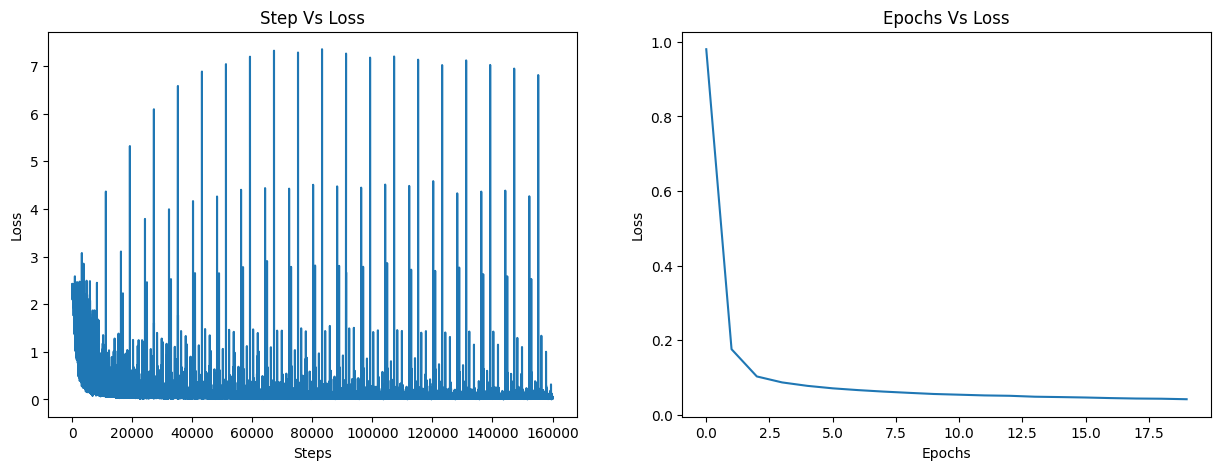

In [29]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(step_losses)
axes[0].set_title("Step Vs Loss")
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[1].plot(epoch_losses)
axes[1].set_title("Epochs Vs Loss")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

In [30]:
model_name = "Deformable_U-Net_8000_v19_L_D_25_epoch.pth"
torch.save(model.state_dict(), model_name)

In [31]:
device = "cpu"
device = torch.device(device)
print(device)

cpu


In [32]:
model_path = "Deformable_U-Net_8000_v19_L_D_25_epoch.pth"
model_ = DUNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))
model_.eval()

UNet(
  (contracting_11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contracting_21): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_22): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contr

In [41]:
test_batch_size = 10
val_dir="C:/Users/yashs/Woodscape/WoodScape/data/rgb_images/val_10"
val_label_dir="C:/Users/yashs/Woodscape/WoodScape/data/semmantic_annotations/val_10"
dataset = WoodscapeDataset(val_dir,val_label_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size,shuffle=True)

In [42]:
import time
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
pred_time_start=time.time()
Y_pred = model_(X)
pred_time_end=time.time()
mean_pred_time=(pred_time_end-pred_time_start)/test_batch_size
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 512, 512])
torch.Size([10, 512, 512])


In [43]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

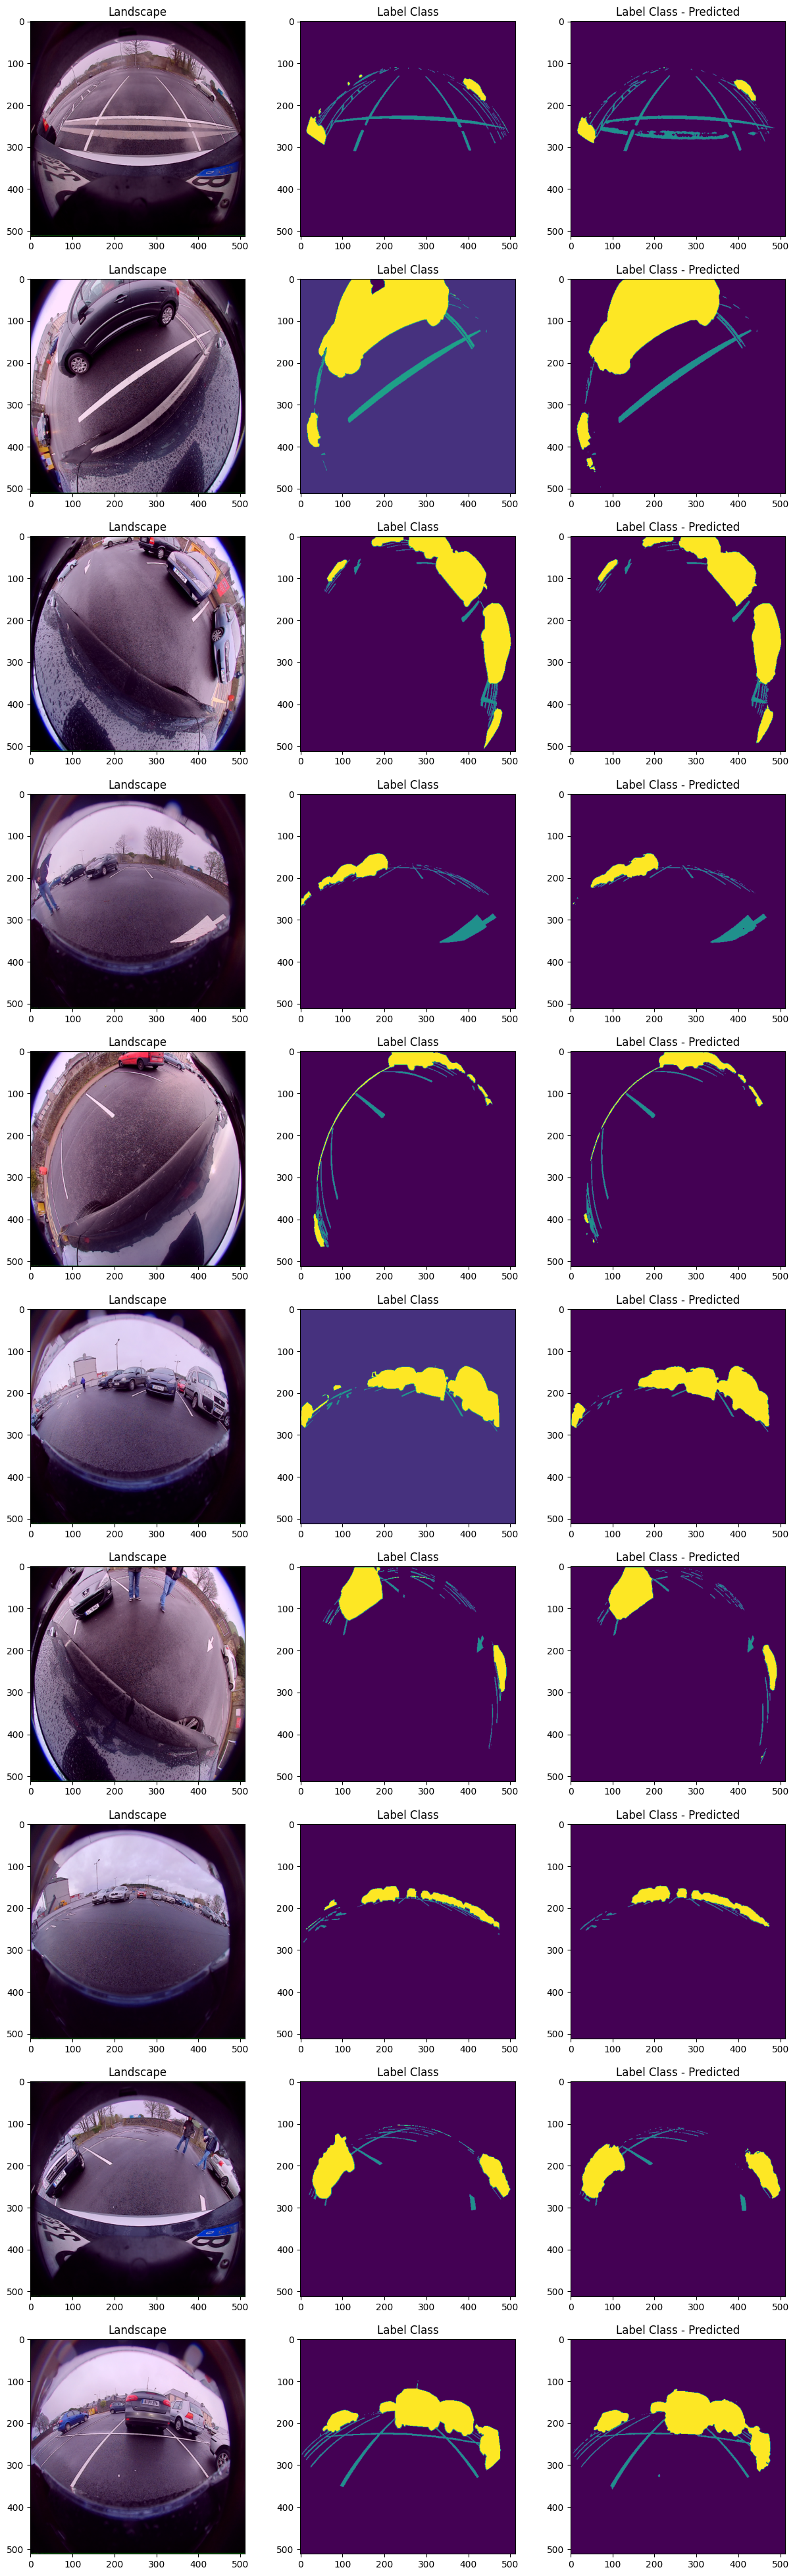

In [44]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [52]:
print("MIOU Score : ",sum(iou_scores) / len(iou_scores))


MIOU Score :  0.866


In [53]:
print("Average Prediction Time : ",mean_pred_time)

Average Prediction Time :  12.579411721229553
